# Accentual Responsion in Pindar

*100 shuffled Aristophanic antistrophic tetrameter null:* **0.810**

In [13]:
from collections import Counter

from src.stats_comp import compatibility_corpus, compatibility_ratios_to_stats

all_sets = compatibility_corpus('data/compiled/')
total_comp = compatibility_ratios_to_stats(all_sets)

print(f'Total compatibility: {total_comp}')
print(all_sets)

found_zero = False
number_of_variables = 0
value_distribution = {
    '0': 0,
    '1/4': 0,
    '1/3:': 0,
    '1/2': 0,
    '2/3': 0,
    '3/4': 0,
    '1': 0,
}

values = []
for element in all_sets:
    for subelement in element:
        for subsubelement in subelement:
            for value in subsubelement:
                number_of_variables += 1
                values.append(value)
                if value == 0.0:
                    found_zero = True
                
if found_zero:
    print("Found zero")
print(f'Number of variables: {number_of_variables}')

count_dict = Counter(values)
print(count_dict)

def round_nested(d, ndigits=3):
    """
    Recursively rounds all floats in a nested dict/list structure.
    """
    if isinstance(d, dict):
        return {k: round_nested(v, ndigits) for k, v in d.items()}
    elif isinstance(d, list):
        return [round_nested(v, ndigits) for v in d]
    elif isinstance(d, float):
        return round(d, ndigits)
    else:
        return d

print(round_nested(all_sets))

Total compatibility: 0.6705685618729097
[[[[0.6923076923076923, 0.7692307692307693, 0.5384615384615384, 0.6153846153846154, 0.5384615384615384, 0.6153846153846154, 0.7692307692307693, 0.8461538461538461, 0.6153846153846154, 0.9230769230769231, 1.0], [0.6153846153846154, 0.6153846153846154, 0.5384615384615384, 0.9230769230769231, 0.6923076923076923, 0.5384615384615384, 0.5384615384615384, 0.5384615384615384, 0.6923076923076923, 0.7692307692307693, 0.6153846153846154, 0.5384615384615384, 0.6923076923076923, 0.6153846153846154, 0.8461538461538461, 0.6923076923076923, 0.7692307692307693, 0.5384615384615384, 0.5384615384615384, 0.6153846153846154, 0.5384615384615384, 1.0, 1.0], [0.5384615384615384, 0.5384615384615384, 0.5384615384615384, 0.6153846153846154, 0.5384615384615384, 0.7692307692307693, 0.7692307692307693, 0.6153846153846154, 0.7692307692307693, 0.5384615384615384, 0.6923076923076923, 0.6923076923076923, 0.5384615384615384, 0.7692307692307693, 0.6923076923076923, 0.538461538461538

### Heatmap

Let's first make a text matrix of the sylls of the first strophe, to have something as a handy reference overlay on the heatmap.

In [2]:
from lxml import etree

# Load XML
tree = etree.parse("data/compiled/fourth_pythian.xml")
root = tree.getroot()

# Get first <strophe>
first_strophe = root.find(".//strophe[1]")

text_matrix = []

# Iterate over <l> children
for l in first_strophe.findall("l"):
    line_sylls = []
    buffer = ""
    prev_resolved = False
    
    for syll in l.findall("syll"):
        resolved = syll.get("resolution") == "True"
        content = syll.text or ""
        
        if prev_resolved and resolved:
            # join with previous
            buffer += content
        else:
            # flush previous buffer if any
            if buffer:
                line_sylls.append(buffer)
            buffer = content
        
        prev_resolved = resolved
    
    # Append any remaining buffer
    if buffer:
        line_sylls.append(buffer)
    
    text_matrix.append(line_sylls)

# Print the shape
num_rows = len(text_matrix)
row_lengths = [len(row) for row in text_matrix]
print(f"Number of rows: {num_rows}")
print(f"Length of each row: {row_lengths}")

Number of rows: 23
Length of each row: [11, 23, 20, 15, 15, 18, 14, 8, 11, 23, 20, 15, 15, 18, 14, 8, 19, 19, 15, 20, 16, 12, 19]


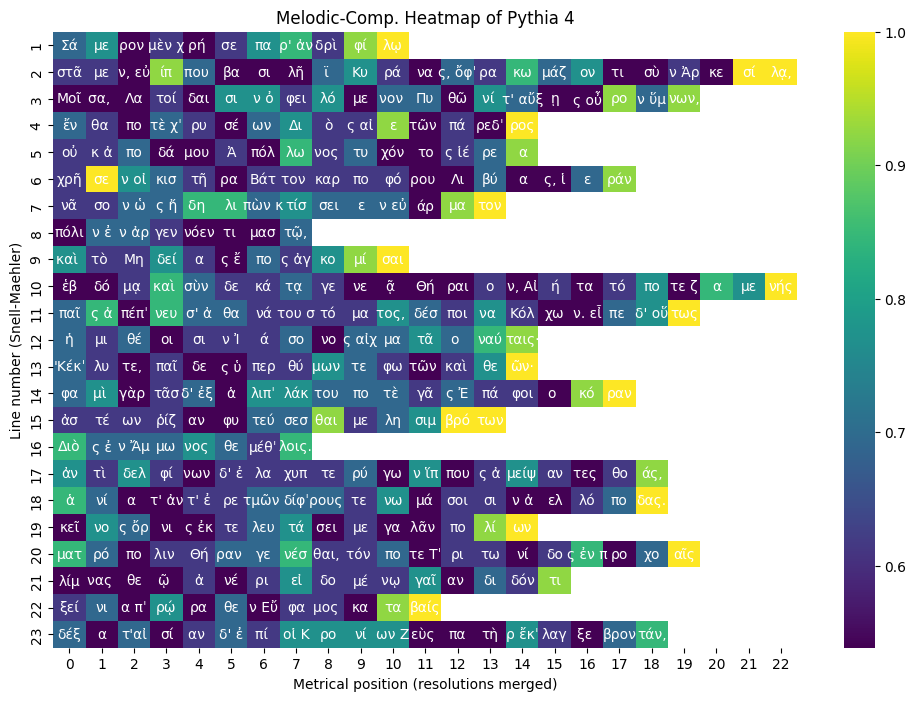

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = all_sets

# Unwrap nested tensor structure (since just one song, redundant cantica and play dims)
data_matrix = data[0][0]

# -----------------------------
# 3. Shape check
# -----------------------------
num_rows_text = len(text_matrix)
num_rows_data = len(data_matrix)

if num_rows_text != num_rows_data:
    raise ValueError(f"Number of rows mismatch: text_matrix={num_rows_text}, data_matrix={num_rows_data}")

max_len_text = max(len(row) for row in text_matrix)
max_len_data = max(len(row) for row in data_matrix)

if max_len_text != max_len_data:
    raise ValueError(f"Row length mismatch: max text length={max_len_text}, max data length={max_len_data}")

# -----------------------------
# 4. Pad numeric matrix for heatmap
# -----------------------------
max_len = max_len_data
padded_data = np.full((len(data_matrix), max_len), np.nan)
for i, row in enumerate(data_matrix):
    padded_data[i, :len(row)] = row

# -----------------------------
# 5. Plot heatmap with text overlay
# -----------------------------
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    padded_data, 
    cmap="viridis", 
    mask=np.isnan(padded_data), 
    cbar=True
)

# Overlay text
for i, row in enumerate(text_matrix):
    for j, val in enumerate(row):
        ax.text(
            j + 0.5, i + 0.5,  # center in cell
            val,
            ha='center', va='center',
            color='white', fontsize=10
        )

plt.xlabel("Metrical position (resolutions merged)")
plt.ylabel("Line number (Snell-Maehler)")
plt.title("Melodic-Comp. Heatmap of Pythia 4")
plt.yticks(ticks=np.arange(len(data_matrix)) + 0.5, labels=np.arange(1, len(data_matrix)+1))

plt.savefig("media/plots/heatmap_pythia_4_comp.png", dpi=400) # add arg bbox_inches='tight' to make it tight
plt.show()

# Barys

[[[[0.15384615384615385, 0.0, 0.46153846153846156, 2.3076923076923075, 0.9230769230769231, 0.0, 0.0, 0.46153846153846156, 0.0, 0.0, 3.230769230769231], [0.9230769230769231, 0.0, 0.9230769230769231, 1.5384615384615385, 3.230769230769231, 0.0, 0.0, 2.3076923076923075, 0.0, 0.0, 5.538461538461538, 0.0, 5.538461538461538, 0.0, 0.0, 4.3076923076923075, 1.5384615384615385, 0.0, 0.0, 1.5384615384615385, 0.0, 0.0, 5.538461538461538], [0.15384615384615385, 0.0, 0.0, 0.9230769230769231, 4.3076923076923075, 0.0, 0.0, 0.9230769230769231, 0.0, 0.0, 1.5384615384615385, 0.0, 8.461538461538462, 0.0, 0.46153846153846156, 3.230769230769231, 3.230769230769231, 0.0, 0.0, 6.923076923076923], [0.46153846153846156, 0.0, 0.0, 1.5384615384615385, 0.0, 0.0, 0.9230769230769231, 0.0, 0.0, 1.5384615384615385, 0.15384615384615385, 8.461538461538462, 0.0, 0.46153846153846156, 6.923076923076923], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15384615384615385, 1.5384615384615385, 5.538461538461538, 0.0, 0.46153846153846156, 1.538

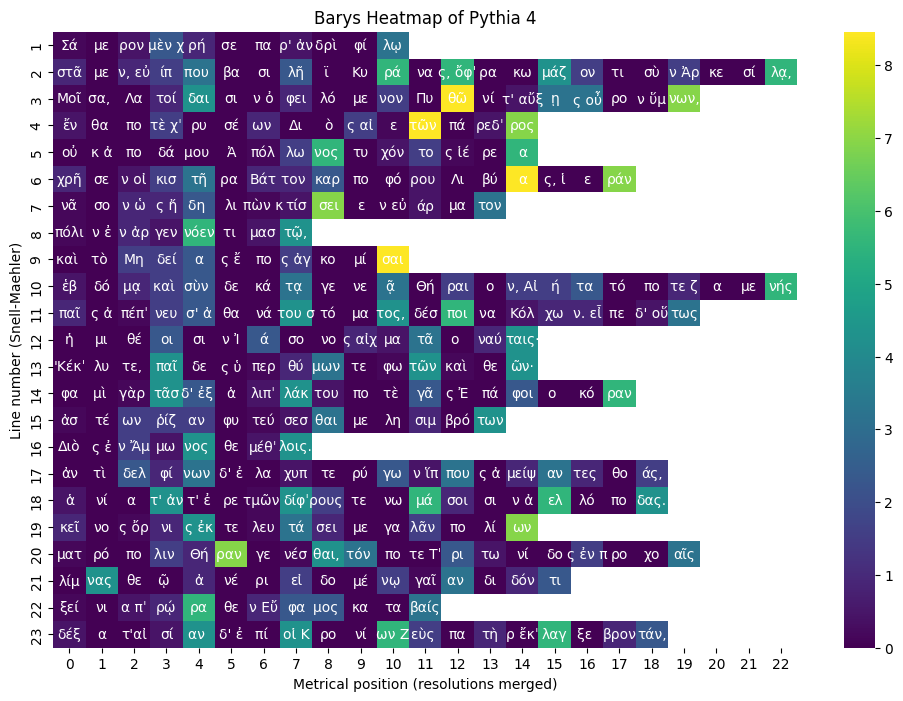

In [4]:
from src.stats_barys_float import float_barys_corpus

dir = "data/compiled/"
float_corpus = float_barys_corpus(dir)
print(float_corpus)

# -----------------------------

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = float_corpus

# Unwrap nested tensor structure (since just one song, redundant cantica and play dims)
data_matrix = data[0][0]

# -----------------------------
# 3. Shape check
# -----------------------------
num_rows_text = len(text_matrix)
num_rows_data = len(data_matrix)

if num_rows_text != num_rows_data:
    raise ValueError(f"Number of rows mismatch: text_matrix={num_rows_text}, data_matrix={num_rows_data}")

max_len_text = max(len(row) for row in text_matrix)
max_len_data = max(len(row) for row in data_matrix)

if max_len_text != max_len_data:
    raise ValueError(f"Row length mismatch: max text length={max_len_text}, max data length={max_len_data}")

# -----------------------------
# 4. Pad numeric matrix for heatmap
# -----------------------------
max_len = max_len_data
padded_data = np.full((len(data_matrix), max_len), np.nan)
for i, row in enumerate(data_matrix):
    padded_data[i, :len(row)] = row

# -----------------------------
# 5. Plot heatmap with text overlay
# -----------------------------
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    padded_data, 
    cmap="viridis", 
    mask=np.isnan(padded_data), 
    cbar=True
)

# Overlay text
for i, row in enumerate(text_matrix):
    for j, val in enumerate(row):
        ax.text(
            j + 0.5, i + 0.5,  # center in cell
            val,
            ha='center', va='center',
            color='white', fontsize=10
        )

plt.xlabel("Metrical position (resolutions merged)")
plt.ylabel("Line number (Snell-Maehler)")
plt.title("Barys Heatmap of Pythia 4")
plt.yticks(ticks=np.arange(len(data_matrix)) + 0.5, labels=np.arange(1, len(data_matrix)+1))

plt.savefig("media/plots/heatmap_pythia_4_barys.png", dpi=400) # add arg bbox_inches='tight' to make it tight
plt.show()

Tetrameter 3-strophes barys **baseline**: 0.15

Första 3 strofer i Pythia 4, barys: 0.25

Första 4, barys: 0.092

In [14]:
from src.stats_barys import barys_oxys_metric_corpus

corpus_dict = barys_oxys_metric_corpus('data/compiled', exclude_substr='baseline')

for key, value in corpus_dict.items():
    print(f'\t{key}: {value}')

Total barys match groups in corpus: 0
	barys_metric: 0.0
	oxys_metric: 0.0
	barys_oxys_metric: 0.0


In [4]:
from lxml import etree

from src.stats_barys import barys_accentually_responding_syllables_of_strophes_polystrophic, barys_detailed_print, count_all_barys_oxys_canticum

from src.utils.utils import polystrophic_cantica

barys_detailed_print("data/compiled/test/fourth_pythian_3_strophes.xml", ["py04"])


Canticum: py04
{'barys': 261, 'oxys': 91}
[]
[{('2', 5): 'ίππου ', ('25', 5): 'νάντω', ('48', 5): 'κείνα^ν '}]
[{('3', 13): 'θῶ', ('26', 13): 'νώτω', ('49', 13): 'γείου '}, {('3', 20): 'ν ὕμνων,', ('26', 20): 'ρήμων', ('49', 20): 'νᾶν.'}]
[{('4', 12): 'τῶν ', ('27', 12): 'σπάσσαν', ('50', 12): 'ρήσει '}]
[]
[{('6', 5): 'τῆ', ('29', 5): 'δοίου π', ('52', 5): 'θόντες '}, {('6', 15): 'βύα', ('29', 15): 'λίων ', ('52', 15): 'φέων '}]
[{('7', 9): 'τίσσει', ('30', 9): 'θόντεσ', ('53', 9): 'ρύσῳ '}]
[]
[{('9', 11): 'μίσαι', ('32', 11): 'ροῦ', ('55', 11): 'ρόνῳ'}]
[]
[{('11', 20): "δ' οὕτως", ('34', 20): 'ρούρας', ('57', 20): 'πᾷ'}]
[]
[{('13', 9): 'θύμων ', ('36', 9): "λ' ἥρω", ('59', 9): 'νάστου, '}]
[{('14', 4): 'τᾶσ', ('37', 4): 'χεῖ', ('60', 4): 'ς ὤρθω'}, {('14', 18): 'κόραν', ('37', 18): 'νίαν.', ('60', 18): 'λά^δῳ·'}]
[]
[{('16', 5): 'ν Ἄμμω', ('39', 5): 'βᾶ', ('62', 5): 'ἄμφα_'}, {('16', 9): 'μέθˈλοις.', ('39', 9): 'ν ἅλμᾳ', ('62', 9): 'ρά_νᾳ,'}]
[{('17', 5): 'φίνων ', ('40', 5): 'ρῷ